In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
### Import functions from peak_functions

repository_path = os.path.abspath('..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 12

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-06_02_2023-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [6]:
channel = 0
num_wfs = 100

all_raw_wfs       = np.array(RawTree[f'chan{channel}/rdigi'].array())[:num_wfs]
    
## Subtract baseline
subt_raw_wfs      = pf.subtract_baseline(all_raw_wfs, mode=False, wf_range_bsl=(0,650))

### ## Get and remove saturated events from PMTs
### saturated_evts    = get_saturating_evts_using_pmt_signal(RawTree, num_wfs=num_wfs, pmt_thr=pmt_thr)
### filt_wfs          = remove_waveforms_by_indices(subt_raw_wfs, saturated_evts)
### 
### ## Zero suppression
### zs_raw_wfs        = noise_suppression(filt_wfs, threshold=sipm_thr)
### 
### ## Remove events with no signal in the ROI
### empty_evts        = np.array([idx for idx, zwf in enumerate(zs_raw_wfs) if np.sum(zwf[peak_range[0]:peak_range[1]])==0])
### filter_empty_zwfs = remove_waveforms_by_indices(zs_raw_wfs, empty_evts)
### subt_raw_wfs_filt = remove_waveforms_by_indices(filt_wfs,   empty_evts)
### 
### ## Get the peaks found in the ROI
### all_peaks         = list(map(get_peaks_peakutils, filter_empty_zwfs))

In [7]:
subt_raw_wfs

array([[  3.72609231,   3.72609231,  12.72609231, ...,   3.72609231,
          2.72609231,  14.72609231],
       [  8.72609231,   9.72609231,   5.72609231, ...,   6.72609231,
         -0.27390769,   0.72609231],
       [ 21.72609231,   7.72609231, -11.27390769, ..., -13.27390769,
        -17.27390769, -14.27390769],
       ...,
       [  2.72609231,   4.72609231,   2.72609231, ...,  24.72609231,
         28.72609231,   6.72609231],
       [  5.72609231,  10.72609231,  10.72609231, ...,  -1.27390769,
          0.72609231,  -3.27390769],
       [ -7.27390769,  -6.27390769,   2.72609231, ...,  -2.27390769,
         -0.27390769,  10.72609231]])

### PMT

In [15]:
channel  = 12
max_smpl_bsl = 650
all_wfs  = np.array(RawTree[f'chan{channel}/rdigi'].array())
all_cwfs = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl)) for wf in all_wfs])

In [16]:
all_cwfs_flatten = np.concatenate(all_cwfs)

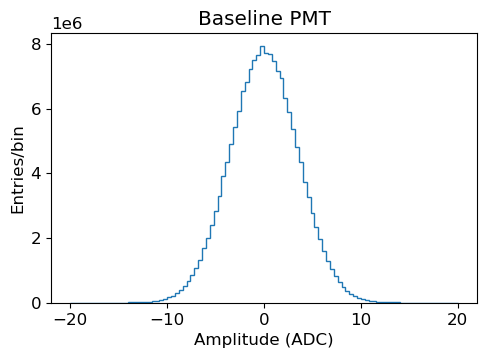

In [24]:
plt.figure(figsize=(5.5, 3.5))
plt.hist(all_cwfs_flatten, bins=100, range=(-20, 20), histtype='step')
plt.xlabel('Amplitude (ADC)')
plt.ylabel('Entries/bin')
plt.title('Baseline PMT');

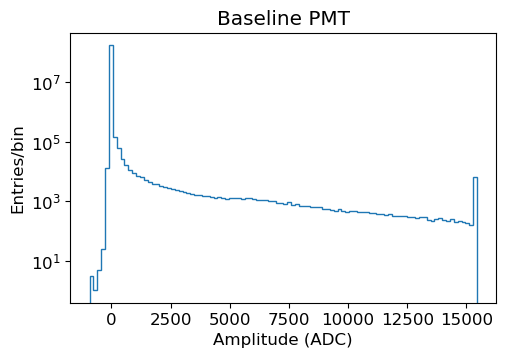

In [34]:
plt.figure(figsize=(5.5, 3.5))
plt.hist(all_cwfs_flatten, bins=100, histtype='step', log=True)
plt.xlabel('Amplitude (ADC)')
plt.ylabel('Entries/bin')
plt.title('Baseline PMT');

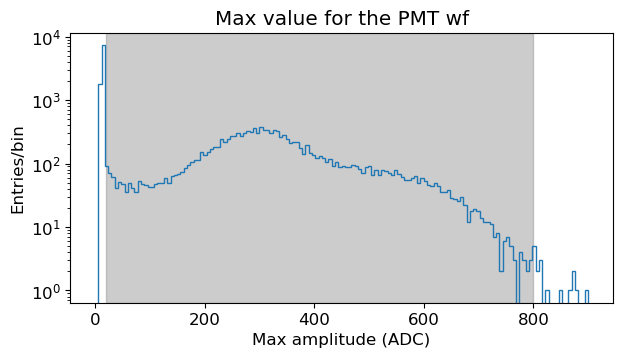

In [44]:
plt.figure(figsize=(7, 3.5))
plt.hist(list(map(max, all_cwfs)), bins=150, range=(0, 900), histtype='step', log=True)
plt.axvspan(20, 800, color='grey', alpha=0.4)
plt.xlabel('Max amplitude (ADC)')
plt.ylabel('Entries/bin')
plt.title('Max value for the PMT wf');

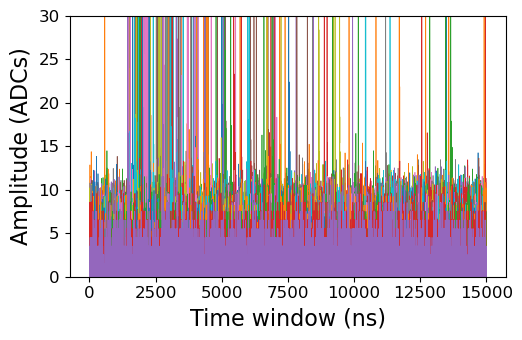

In [21]:
plt.figure(figsize=(5.5, 3.5))
for evt, sel_wf in enumerate(all_cwfs[:200]):
    sel_mask = (sel_wf > 15) & (sel_wf < 20)
    if not np.any(sel_mask):
        continue

    plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.tight_layout()
plt.ylim(0, 30)
plt.show()

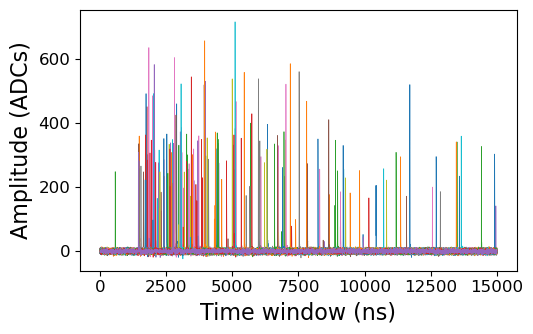

In [46]:
plt.figure(figsize=(5.5, 3.5))
for evt, sel_wf in enumerate(all_cwfs[:200]):
    sel_mask = (sel_wf > 20) & (sel_wf < 800)
    if not np.any(sel_mask):
        continue

    plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.tight_layout()
plt.show()

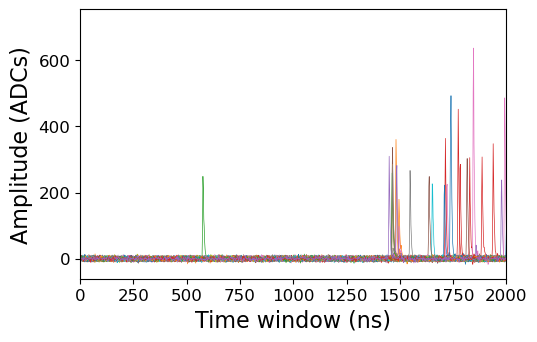

In [47]:
plt.figure(figsize=(5.5, 3.5))
for evt, sel_wf in enumerate(all_cwfs[:200]):
    sel_mask = (sel_wf > 20) & (sel_wf < 800)
    if not np.any(sel_mask):
        continue

    plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 2000)
plt.show()

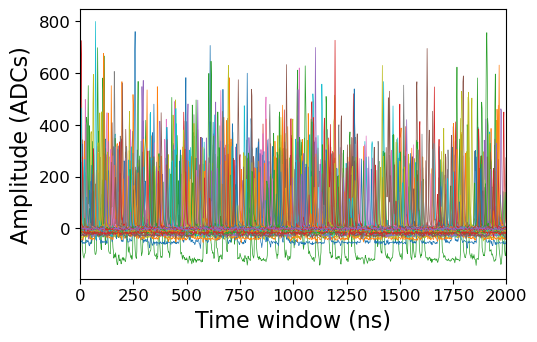

In [52]:
pretrigger_range = (0, 700)
plt.figure(figsize=(5.5, 3.5))
for evt, sel_wf in enumerate(all_cwfs):
    
    if np.any(sel_wf > 800): ## Cosmic cut 1: remove saturating events
        continue

    sel_mask = (sel_wf > 20) & (sel_wf < 800) ## Get events above the baseline
    if not np.any(sel_mask):
        continue
    
    wf_pretrigger = sel_wf[pretrigger_range[0]:pretrigger_range[1]]
    sel_mask2 = wf_pretrigger > 20
    if np.any(sel_mask2):
        plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 2000)
plt.show()

In [70]:
pretrigger_range = (0, 700)
for evt, sel_wf in enumerate(all_cwfs[:1000]):
    
    if np.any(sel_wf > 1000): ## Cosmic cut 1: remove saturating events
        ## plt.figure(figsize=(5.5, 3.5))
        ## plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
        ## plt.title(f'Event {evt}')
        ## plt.xlabel('Time window (ns)', fontsize=16)
        ## plt.ylabel('Amplitude (ADCs)', fontsize=16)
        ## #plt.xlim(0, 2000)
        ## plt.show()
        continue

    sel_mask = (sel_wf > 20) & (sel_wf < 1000) ## Get events above the baseline
    if not np.any(sel_mask):
        continue
    
    wf_pretrigger = sel_wf[pretrigger_range[0]:pretrigger_range[1]]
    sel_mask2 = wf_pretrigger > 20
    if np.any(sel_mask2):
        ## plt.figure(figsize=(5.5, 3.5))
        ## plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
        ## plt.axvspan(0, 1300, color='grey', alpha=0.4)
        ## plt.title(f'Event {evt}')
        ## plt.xlabel('Time window (ns)', fontsize=16)
        ## plt.ylabel('Amplitude (ADCs)', fontsize=16)
        ## #plt.xlim(0, 2000)
        ## plt.show()
        continue

### Trigger SiPMs, deconvolution

In [71]:
channel  = 9
max_smpl_bsl = 650
all_wfs9  = np.array(RawTree[f'chan{channel}/rdigi'].array())
all_cwfs9 = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl)) for wf in all_wfs9])

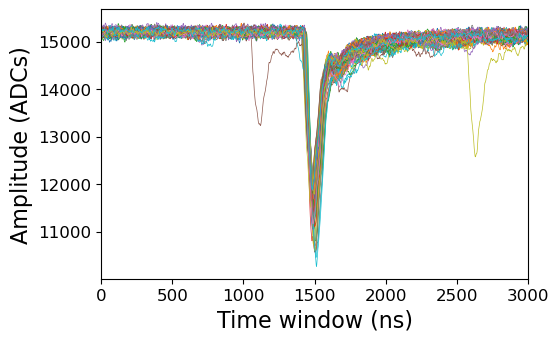

In [76]:
plt.figure(figsize=(5.5, 3.5))
for evt, sel_wf in enumerate(all_wfs9[:100]):
    plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 3000)
plt.show()

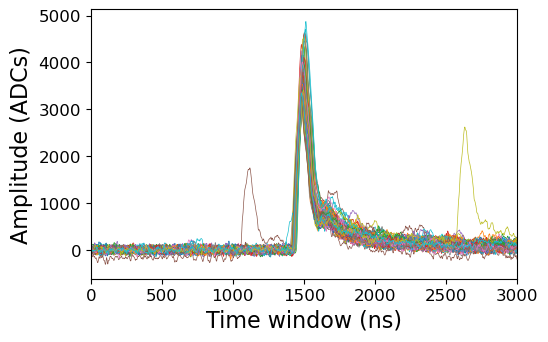

In [75]:
plt.figure(figsize=(5.5, 3.5))
for evt, sel_wf in enumerate(all_cwfs9[:100]):
    plt.plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 3000)
plt.show()

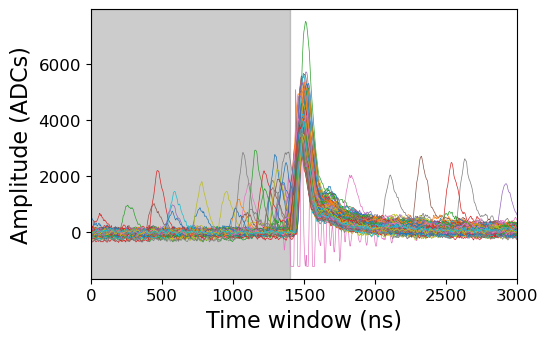

In [84]:
plt.figure(figsize=(5.5, 3.5))
for cwf in all_cwfs9[:1000]:
    wf_pretrigger = cwf[pretrigger_range[0]:pretrigger_range[1]]
    if np.max(wf_pretrigger) > 100:
        plt.plot(2*np.arange(len(cwf)), cwf, linewidth=0.5)
plt.axvspan(0, 1400, color='grey', alpha=0.4)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 3000)
plt.show()

## Normal SiPMs

250
271
379
517
784
1395
1676
1755
1779
1844


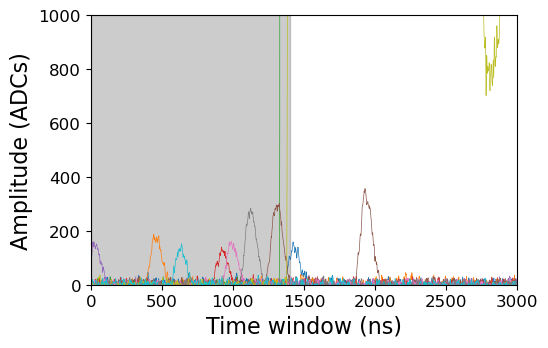

In [116]:
plt.figure(figsize=(5.5, 3.5))
sub_wf0 = pf.subtract_baseline(np.array(RawTree['chan0/rdigi'].array()), mode=False, wf_range_bsl=(0,max_smpl_bsl))
for evt, wf in enumerate(sub_wf0[:2000]):
    wf_pretrigger = wf[pretrigger_range[0]:pretrigger_range[1]]
    if np.max(wf_pretrigger) > 100:
        print(evt)
        plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5)
plt.axvspan(0, 1400, color='grey', alpha=0.4)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 3000)
plt.ylim(0, 1000)
plt.show()

250
271


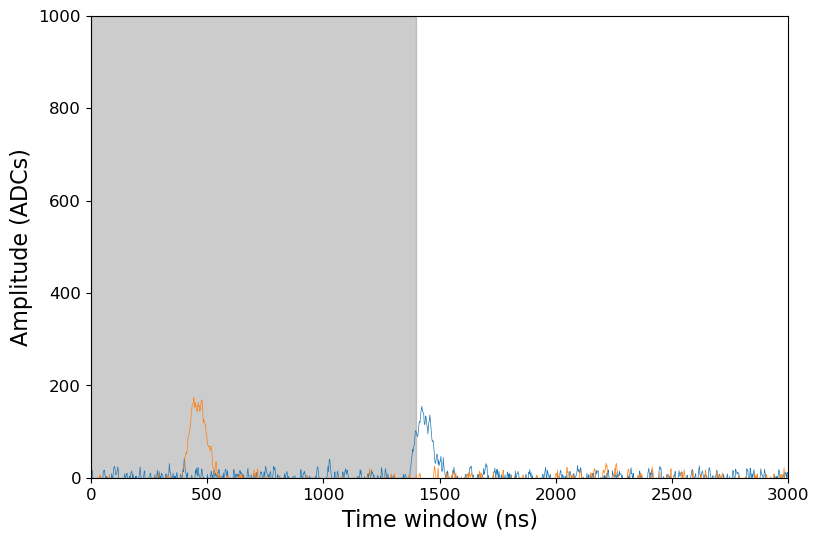

In [121]:
channel  = 12
max_smpl_bsl = 650
pretrigger_range = (0, 700)

all_wfs  = np.array(RawTree[f'chan{channel}/rdigi'].array())
all_cwfs = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl)) for wf in all_wfs])

good_evts = []

for evt, sel_wf in enumerate(all_cwfs[:500]):
    
    if np.any(sel_wf > 1000): ## Cosmic cut 1: remove saturating events
        continue

    sel_mask = (sel_wf > 20) & (sel_wf < 1000) ## Get events above the baseline
    if not np.any(sel_mask):
        continue
    
    sub_wf0 = pf.subtract_baseline(np.array(RawTree['chan0/rdigi'].array()[evt]), mode=False, wf_range_bsl=(0,max_smpl_bsl))

    wf_pretrigger = sub_wf0[pretrigger_range[0]:pretrigger_range[1]]
    if np.max(wf_pretrigger) > 100:
        print(evt)
        plt.plot(2*np.arange(len(sub_wf0)), sub_wf0, linewidth=0.5)
plt.axvspan(0, 1400, color='grey', alpha=0.4)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.xlim(0, 3000)
plt.ylim(0, 1000)
plt.show()

In [109]:
all_sub_wfs = [pf.subtract_baseline(np.array(RawTree[f'chan{ch}/rdigi'].array()), 
                                    mode=False, wf_range_bsl=(0,max_smpl_bsl)) for ch in [0,1,2,4,5,6,7,8]]

all_max_wf_pretrgg = [[np.max(wf[pretrigger_range[0]:pretrigger_range[1]]) for wf in sub_wf] for sub_wf in all_sub_wfs]

In [113]:
all_max_wf_pretrgg;

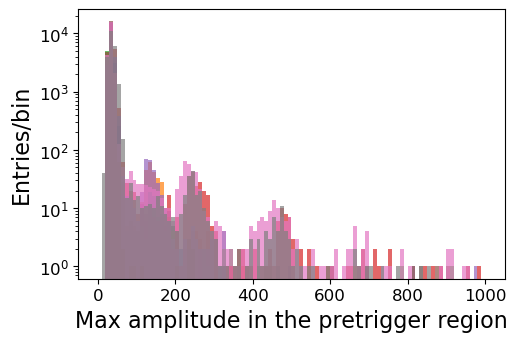

In [112]:
plt.figure(figsize=(5.5, 3.5))
for max_wf_pretrgg, ch in zip(all_max_wf_pretrgg, [0,1,2,4,5,6,7,8]):
    plt.hist(max_wf_pretrgg, bins=100, range=(0, 1000), log=True, alpha=0.7, label=f'Channel {ch}')
plt.xlabel('Max amplitude in the pretrigger region', fontsize=16)
plt.ylabel('Entries/bin', fontsize=16)
plt.legend()
plt.show()

## Main code:

In [96]:
channel  = 12
max_smpl_bsl = 650
pretrigger_range = (0, 700)

all_wfs  = np.array(RawTree[f'chan{channel}/rdigi'].array())
all_cwfs = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl)) for wf in all_wfs])

good_evts = []

for evt, sel_wf in enumerate(all_cwfs[:1000]):
    
    if np.any(sel_wf > 1000): ## Cosmic cut 1: remove saturating events
        continue

    sel_mask = (sel_wf > 20) & (sel_wf < 1000) ## Get events above the baseline
    if not np.any(sel_mask):
        continue
    
    wf_pretrigger = sel_wf[pretrigger_range[0]:pretrigger_range[1]] ## Cosmic cut 2: remove evts with peaks in the pretrigger region
    sel_mask2 = wf_pretrigger > 20
    if np.any(sel_mask2):
        continue

    ## Look at the SiPM wfs
    
    ##Trigger SiPMs
    cwf9  = blr.pmt_deconvolver(np.array(RawTree['chan9/rdigi'] .array())[evt], wf_range_bsl=(0, max_smpl_bsl))
    cwf10 = blr.pmt_deconvolver(np.array(RawTree['chan10/rdigi'].array())[evt], wf_range_bsl=(0, max_smpl_bsl))
    cwf11 = blr.pmt_deconvolver(np.array(RawTree['chan11/rdigi'].array())[evt], wf_range_bsl=(0, max_smpl_bsl))
    
    wf_pretrigger = np.concatenate([cwf[pretrigger_range[0]:pretrigger_range[1]] for cwf in [cwf9, cwf10, cwf11]])
    if np.max(wf_pretrigger) > 1000:
        #plt.plot(2*np.arange(len(cwf9)), cwf9, linewidth=0.5)
        #plt.plot(2*np.arange(len(cwf10)), cwf10, linewidth=0.5)
        #plt.plot(2*np.arange(len(cwf11)), cwf11, linewidth=0.5)
        continue
        
        
    sub_wf0 = pf.subtract_baseline(np.array(RawTree['chan0/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf1 = pf.subtract_baseline(np.array(RawTree['chan1/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf2 = pf.subtract_baseline(np.array(RawTree['chan2/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf4 = pf.subtract_baseline(np.array(RawTree['chan4/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf5 = pf.subtract_baseline(np.array(RawTree['chan5/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf6 = pf.subtract_baseline(np.array(RawTree['chan6/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf7 = pf.subtract_baseline(np.array(RawTree['chan7/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    sub_wf8 = pf.subtract_baseline(np.array(RawTree['chan8/rdigi'].array())[evt], mode=False, wf_range_bsl=(0,max_smpl_bsl))
    
    wf_pretrigger2 = np.concatenate([cwf[pretrigger_range[0]:pretrigger_range[1]] for cwf in [sub_wf0, sub_wf1, sub_wf2, sub_wf4, sub_wf5, sub_wf6, sub_wf7, sub_wf8]])
    if np.max(wf_pretrigger2) > 1000:
        continue
        
    print(evt)
        
    good_evts.append(evt)

1
3
4
5
13
14
15
18
20
21
22
24
28
29
30
33
35
36
37
38
39
43
51
52
53
54
55
56
57
59
61
62
63
65
66
68
69
70
73
74
77
83
85
86
89
91
93
95
96
97
98
99
100
103
104
107
110
111
112
115
116
119
120
121
122
123
124
125
128
129
131
138
142
143
144
146
147
148
150
151
152
155
160
162
167
170
171
174
175
176
178
180
181
182
184
186
187
190
192
193
196
199
200
206
207
209
210
211
212
213
216
217
219
220
221
222
225
226
227
229
230
236
237
239
240
247
248
249
251
252
253
256
257
259
260
262
264
265
268
269
270
276
278
280
281
290
295
298
299
300
301
304
306
307
308
309
310
311
314
315
317
318
320
321
322
323
325
326
327
328
329
330
332
333
334
335
336
337
338
339
343
347
349
351
352
356
357
358
360
361
362
363
364
366
367
369
372
373
374
375
376
377
378
382
383
385
386
387
389
390
391
392
393
396
397
398
399
403
404
405
407
408
412
413
414


KeyboardInterrupt: 

In [95]:
good_evts

[930]

In [ ]:
channel = 12
max_smpl_bsl = 650
pretrigger_range = (0, 700)

pmt_wfs = np.array(RawTree[f'chan12/rdigi'].array())

# Extract SiPM waveforms
sipm_channels = ['chan9', 'chan10', 'chan11']
sipm_wfs = [blr.pmt_deconvolver(np.array(RawTree[ch].array())[:, :max_smpl_bsl]) for ch in sipm_channels]

# Subtract baselines for other channels
baseline_channels = [f'chan{i}' for i in range(9) if i not in [3, 9, 10, 11]]
baseline_wfs = [
    blr.pmt_deconvolver(np.array(RawTree[ch].array())[:, :max_smpl_bsl], wf_range_bsl=(0, max_smpl_bsl))
    for ch in baseline_channels
]

good_evts = []

for evt, sel_wf in enumerate(pmt_wfs[:1000]):
    if np.any(sel_wf > 1000):  # Cosmic cut 1: remove saturating events
        continue

    sel_mask = (sel_wf > 20) & (sel_wf < 1000)  # Get events above the baseline
    if not np.any(sel_mask):
        continue

    wf_pretrigger = sel_wf[pretrigger_range[0]:pretrigger_range[1]]  # Cosmic cut 2: remove evts with peaks in the pretrigger region
    sel_mask2 = wf_pretrigger > 20
    if np.any(sel_mask2):
        continue

    wf_pretrigger2 = np.concatenate(sipm_wfs)
    if np.max(wf_pretrigger2[evt]) > 100:
        continue

    wf_pretrigger3 = np.concatenate(baseline_wfs)
    if np.max(wf_pretrigger3[evt]) > 100:
        continue

    good_evts.append(evt)
